In [1]:
import os
import pandas as pd
import geopandas as geo
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from feature_engine.encoding import OrdinalEncoder


from xgboost import XGBRegressor


import mlflow
from mlflow.tracking.client import MlflowClient


# Dataset - Metadata
Source: https://www.kaggle.com/datasets/camnugent/california-housing-prices

Dataset: The data pertains to the houses found in a given California district and some summary stats about them based on the 1990 census data.

1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea


# Explorative data analysis

In [2]:
# Read-in data
house_prices = pd.read_csv(
    filepath_or_buffer="housing.csv", sep=","
)
house_prices.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
# Descriptive stats
house_prices.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


<Axes: >

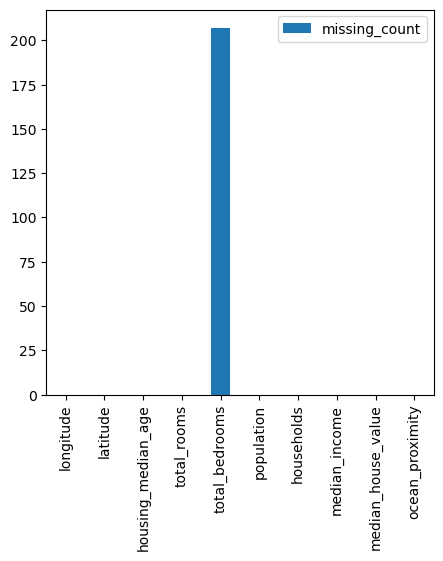

In [4]:
# Missing values
missing_values = pd.DataFrame(house_prices.isna().sum(), columns=["missing_count"])
missing_values.plot(kind="bar", figsize=(5, 5))

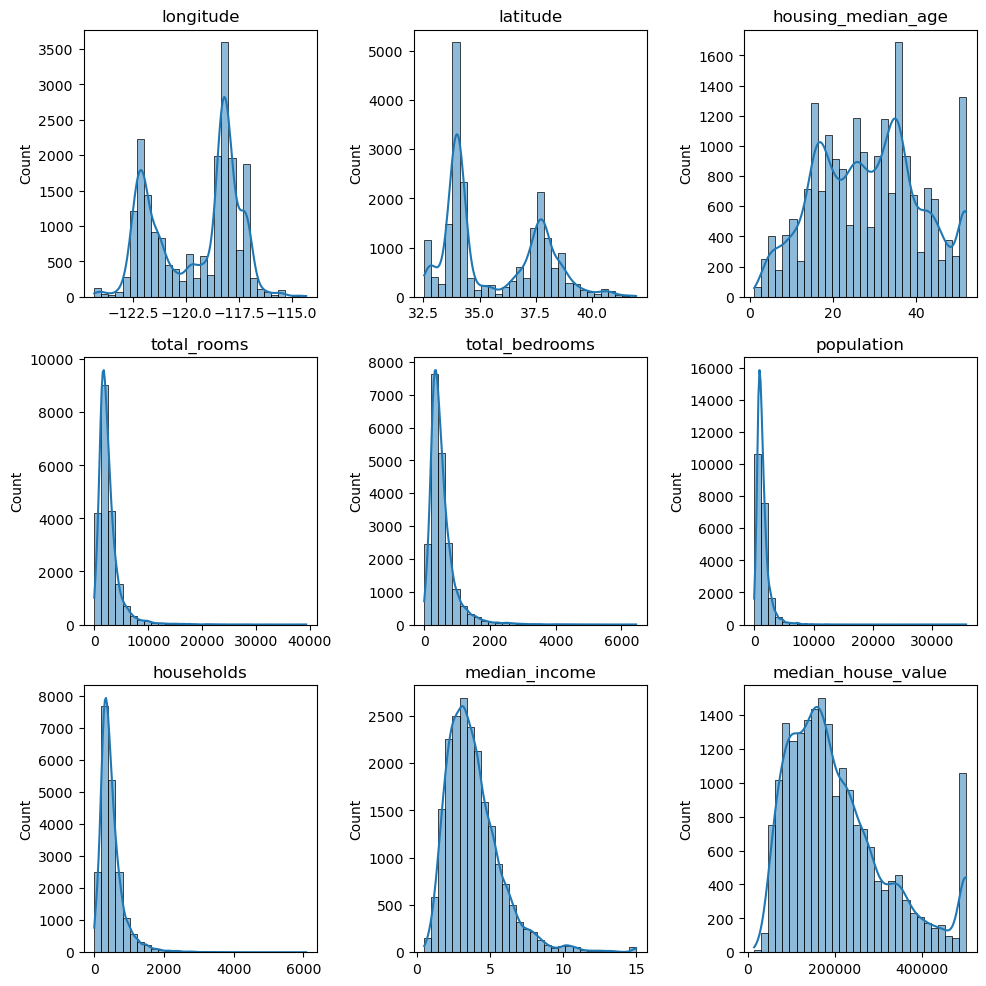

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
# plot each col onto one ax
for col, ax in zip(house_prices.columns, axes.flat):
    #house_prices[col].plot.hist(ax=ax, rot=0)
    sns.histplot(data=house_prices, x=col, kde=True, bins=30, ax=ax)
    ax.set_title(col)
    ax.set(xlabel=None)
fig.tight_layout(pad=1.2)
plt.show()

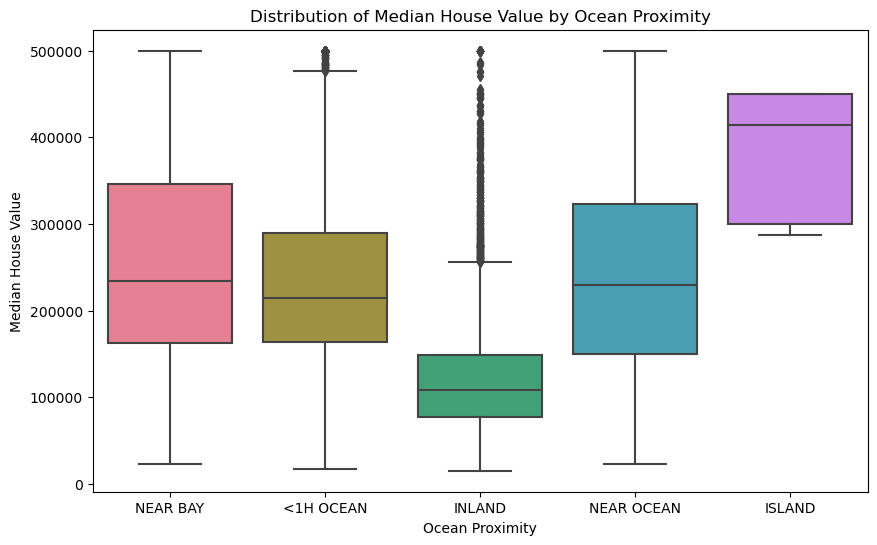

In [6]:
# Categorical feature
plt.figure(figsize=(10, 6))
sns.boxplot(data=house_prices, x='ocean_proximity', y='median_house_value', orient="v", palette="husl")
plt.xlabel('Ocean Proximity')
plt.ylabel('Median House Value')
plt.title('Distribution of Median House Value by Ocean Proximity')
plt.show()

In [7]:
# Map
#ca = geo.read_file("CA_State_TIGER2016.shp")
#print(ca.head())
#ca.crs = {'init' :'epsg:4326'}
#ca.head()
#ca = ca.set_crs("epsg:4326")
#print(ca.crs)
#
#ca.boundary.plot(color='Black', linewidth=.4, aspect=1)
#plt.scatter(data=house_prices, x="longitude", y="latitude")
#house_prices.plot(kind='scatter', x='longitude', y='latitude', alpha=0.5, 
#        s=house_prices['population'] / 50, label='population', c='median_house_value', 
#        cmap=plt.get_cmap('jet'), figsize=(20,13))

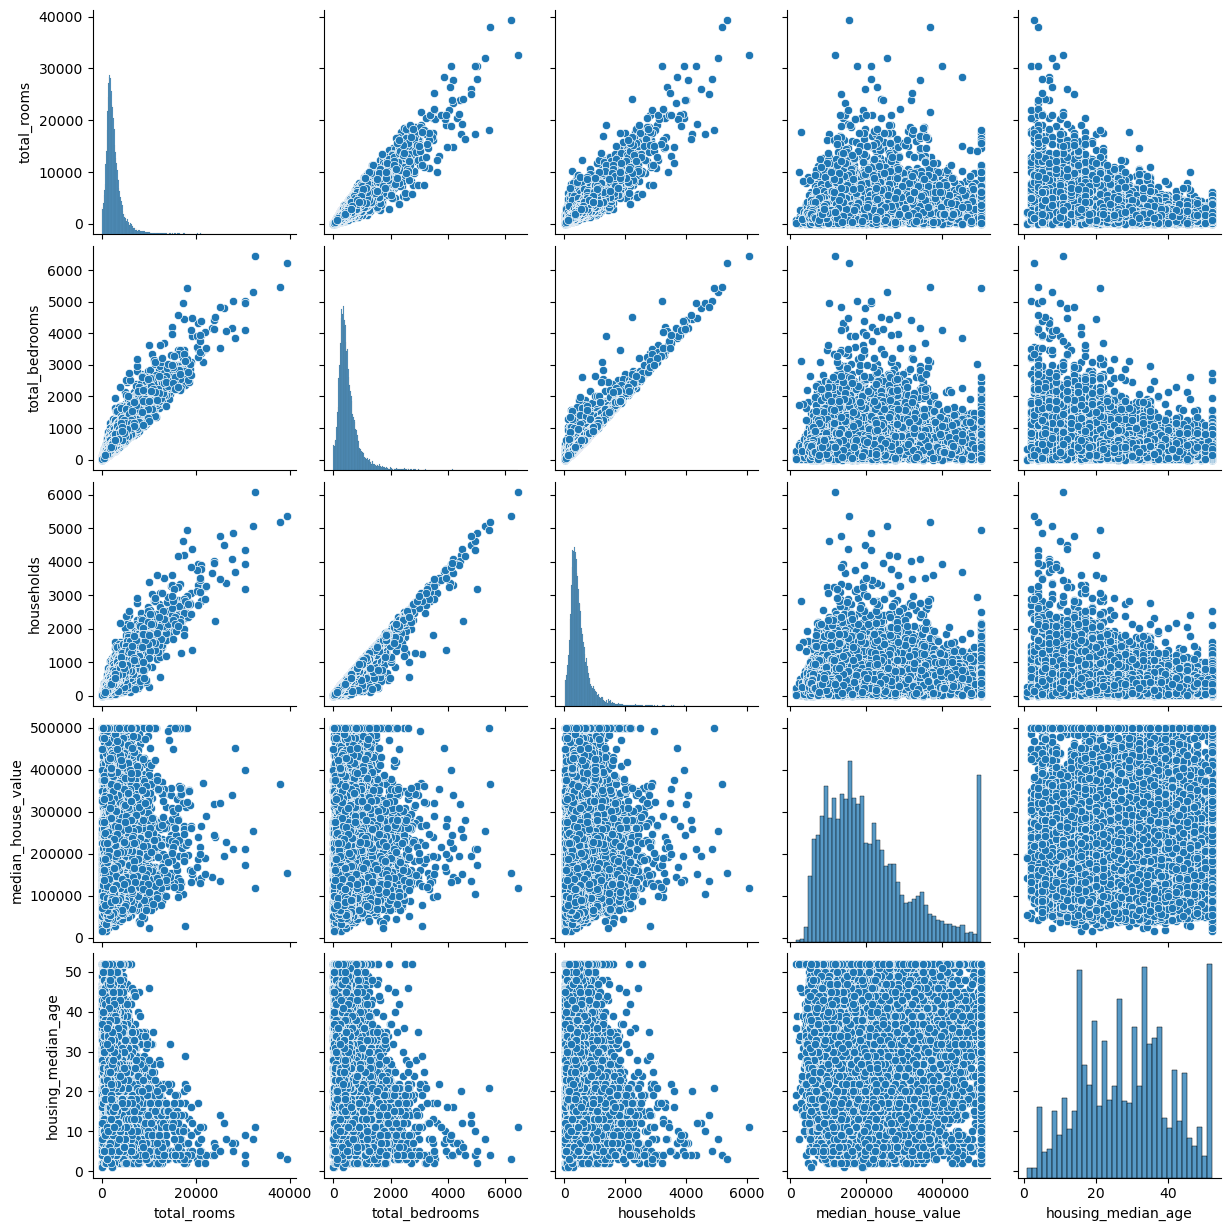

In [8]:
# Correlations
sns.pairplot(data=house_prices[["total_rooms", "total_bedrooms", "households","median_house_value", "housing_median_age"]])


Note from the correlation pair plot that `total_bedrooms` correlates with `households` and `total_rooms` which makes sense as the number of bedrooms are part of total rooms and the more households are present within a block, the more bedrooms would be needed. Therefore we can use the existing features to infer the missing values of `total_bedrooms`.

# Data preprocessing

In [9]:
# Preprocessing -> imputation 
house_prices_numeric = house_prices.drop("ocean_proximity", axis=1)
iter_imputer = IterativeImputer()
house_prices_imputed=iter_imputer.fit_transform(house_prices_numeric)

# Reformat as pandas df
house_prices_imputed = pd.DataFrame(house_prices_imputed, columns=house_prices_numeric.columns)
print(house_prices_imputed.isna().sum())
house_prices_imputed.describe()


longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.909715,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.140245,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,-112.080009,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [10]:
# Add ocean_proximity to imputed df
house_prices_imputed["ocean_proximity"] = house_prices["ocean_proximity"]

In [11]:
# Change category designation
print(house_prices_imputed["ocean_proximity"].unique())
house_prices_imputed["ocean_proximity"] = house_prices_imputed["ocean_proximity"].str.replace("<", "")
print(house_prices_imputed["ocean_proximity"].unique())

['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']
['NEAR BAY' '1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']


In [12]:
print(house_prices_imputed.dtypes)

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object


In [13]:
# Train test split
def create_train_test_sets(target:str, split_size:float, random_state:int, shuffle_data:bool, to_csv:bool, train_test_storage_path:str):
    """ 
    :param target: target for prediction
    :param split_size: size of the train and test split
    :param random_state: setting number for pseudo-random generator
    :param shuffle_data: if True, data will be shuffeled
    :param to_csv: if True, data will be stored to file
    :param train_test_storage_path: path to folder for data storage of train and test sets
    
    :return: dict with X_train, X_test, y_train, y_test
    """

    X = house_prices_imputed.drop(target, axis=1) 
    y = house_prices_imputed[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=random_state, shuffle=shuffle_data)

    for set in [X_train, X_test, y_train, y_test]:
        print(set.shape)

    # Create storage folder for train and test sets
    if not os.path.exists(train_test_storage_path):
        os.makedirs(train_test_storage_path)

    X_train.to_csv(path_or_buf=train_test_storage_path + "X_train.csv",index=False, sep=";")
    X_test.to_csv(path_or_buf=train_test_storage_path + "X_test.csv",index=False, sep=";")
    y_train.to_csv(path_or_buf=train_test_storage_path + "y_train.csv",index=False, sep=";")
    y_test.to_csv(path_or_buf=train_test_storage_path + "y_test.csv" ,index=False, sep=";")

    train_test_dict = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }

    return train_test_dict

# Prediction and MLflow

In [14]:
# MLflow Run

def create_mlflow_run(experiment_name:str, params:dict, train_test_data_path:str, train_test_dict:dict, pipeline):
    """
    :param experiment_name: name of the experiment for the MLflow workflow
    :param params: dictionary with hyperparameters of the algorithm
    :param train_test_data_path: path to folder for data storage of train and test sets
    :param train_test_dict: dict with train and test sets for training and performance measures
    :param pipeline: pipeline object of respective algorithm

    :return: None
    """
    mlflow.set_tracking_uri("sqlite:///mlruns.db")
    mlflow.set_experiment(experiment_name)
    run_name = "mlflow_run_" + experiment_name + "_" + str(datetime.now())[:-7]
    print(run_name)
    with mlflow.start_run(run_name=run_name):
        pipeline = pipeline.fit(train_test_dict["X_train"], train_test_dict["y_train"])
        pred_train = pipeline.predict(train_test_dict["X_train"])
        pred_test = pipeline.predict(train_test_dict["X_test"])
        performance_dict = {"r2_train": r2_score(y_true=train_test_dict["y_train"], y_pred=pred_train),
                            "r2_test": r2_score(y_true=train_test_dict["y_test"], y_pred=pred_test),
                            "mean_squared_error_train": mean_squared_error(y_true=train_test_dict["y_train"], y_pred=pred_train),
                            "mean_squared_error_test": mean_squared_error(y_true=train_test_dict["y_test"], y_pred=pred_test),
                            "mean_absolut_error_train": mean_absolute_error(y_true=train_test_dict["y_train"], y_pred=pred_train),
                            "mean_absolut_error_test": mean_absolute_error(y_true=train_test_dict["y_test"], y_pred=pred_test)
                            }

        # MLFlow loggings
        for key, value in performance_dict.items():
            mlflow.log_metric(key, value)

        for key, value in params.items():  
            mlflow.log_param(key, value)

        mlflow.log_artifact(local_path=train_test_data_path)  #"train_test_data/"

        mlflow.sklearn.log_model(sk_model=pipeline, artifact_path="model")

## Linear Regression

In [15]:
# Linreg runs
split_size = 0.2
random_state = 21
shuffle_data = True

linreg_train_test_dict = create_train_test_sets(target="median_house_value", 
                                                split_size=split_size, 
                                                random_state=random_state, 
                                                shuffle_data=True, 
                                                to_csv=True, 
                                                train_test_storage_path="train_test_data_linreg/")

linreg_params= {
    "fit_intercept": True
}

linreg_pipe = Pipeline([
    # --- Label Encoder --- #
    ("ordinal_encoder", OrdinalEncoder(encoding_method="ordered")),
    # --- Regressor --- #
    ("regressor", LinearRegression(**linreg_params))
])                                    

create_mlflow_run(experiment_name="house_price_linreg", 
                  params=linreg_params, 
                  train_test_data_path="train_test_data_linreg/", 
                  train_test_dict=linreg_train_test_dict, 
                  pipeline=linreg_pipe)

(16512, 9)
(4128, 9)
(16512,)
(4128,)


2023/04/14 11:56:36 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/04/14 11:56:36 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


mlflow_run_house_price_linreg_2023-04-14 11:56:36


/Users/pdanninger/opt/miniconda3/envs/dsc_conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## XGBoost

In [16]:
# XBG runs
split_size = 0.3
random_state = 10
shuffle_data = True

xgb_train_test_dict = create_train_test_sets(target="median_house_value", 
                                                split_size=split_size, 
                                                random_state=random_state, 
                                                shuffle_data=True, 
                                                to_csv=True, 
                                                train_test_storage_path="train_test_data_xgb/")
                                    
xgb_params = {"subsample": 0.85, 
              "n_estimators": 30,
              "max_depth": 6,
              "learning_rate": 0.15,
              "colsample_bytree": 0.85,
              "lambda": 0.5,
              "use_label_encoder": False, 
              "silent": True,
              "verbosity": 0,
              "alpha": 0.5}


xgb_pipe = Pipeline([
    # --- Label Encoder --- #
    ("ordinal_encoder", OrdinalEncoder(encoding_method="ordered")),
    # --- Regressor --- #
    ("regressor", XGBRegressor(**xgb_params))
])

create_mlflow_run(experiment_name="house_price_xgb", 
                  params=xgb_params, 
                  train_test_data_path="train_test_data_xgb/", 
                  train_test_dict=xgb_train_test_dict, 
                  pipeline=xgb_pipe)

(14448, 9)
(6192, 9)
(14448,)
(6192,)
mlflow_run_house_price_xgb_2023-04-14 11:56:39


/Users/pdanninger/opt/miniconda3/envs/dsc_conda/lib/python3.10/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname OCEAN identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


## Model Registration in MLflow

In [17]:
# Register model
def register_mlflow_model(run_id:str, experiment_name:str, stage:str):
    """
    :param run_id: id of Mlflow run
    :param experiment_name: name of the experiment for the MLflow workflow
    :param stage: name of the stage to which the model shall be set to
    
    :return: None
    """
    model_uri = "runs:/" + run_id + "/model"
    mlflow.set_tracking_uri("sqlite:///mlruns.db")
    model_details = mlflow.register_model(model_uri=model_uri, name=experiment_name)
    client = MlflowClient()
    client.transition_model_version_stage(
        name=model_details.name,
        version=model_details.version,
        stage=stage
    )

to_production = True

# ---- Change stage of registered model to production ---- #
if to_production:
    run_id = "41ed2d9e7b504c8f9f986a1e54b06853"
    register_mlflow_model(run_id=run_id,
                         experiment_name="house_price_xgb",
                         stage="Production")
    

2023/04/14 11:56:41 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/04/14 11:56:41 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
Registered model 'house_price_xgb' already exists. Creating a new version of this model...
2023/04/14 11:56:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: house_price_xgb, version 2
Created version '2' of model 'house_price_xgb'.


## Prediction with registered Mlflow model

In [18]:
# Create new house data for prediction
new_data_column_names = house_prices_imputed.loc[:, house_prices_imputed.columns != "median_house_value"].columns
new_data_list = [-122, 40, 20, 2000, 300, 157, 120, 3.5, "INLAND"]
new_data = pd.DataFrame(new_data_list).T
new_data.columns = new_data_column_names
new_data["ocean_proximity"] = new_data["ocean_proximity"].astype("category")
for col in new_data.columns[0:8]:
    new_data[col] = pd.to_numeric(new_data[col], errors="coerce")

In [19]:
# Predict with registered model
def make_prediction(experiment_name:str, stage:str, new_data:pd.DataFrame):
    """
    :param experiment_name: name of the experiment for the MLflow workflow
    :param stage: name of the stage to which the model shall be set to
    :param new_data: data input of new data for prediction

    :return: None
    """

    # ---- Load model ---- #
    mlflow.set_tracking_uri("sqlite:///mlruns.db")
    loaded_model = mlflow.sklearn.load_model(
        model_uri=f"models:/{experiment_name}/{stage}"
    )

    # ---- Predict data ---- #
    # House price prediction for test data
    prediction = loaded_model.predict(X=new_data)
    print("House price prediction for test_data: " + str(prediction[0]) + "$")


to_prediction = True

if to_prediction:
    make_prediction(experiment_name="house_price_xgb", 
                    stage="Production", 
                    new_data=new_data)
    

House price prediction for test_data: 149603.38$
